In [16]:
import xarray as xr
import pandas as pd
import numpy as np
import copy

import glob

import xrft
import finufft

from uncertainties import ufloat
from uncertainties import unumpy as unp
from uncertainties import umath

from datetime import datetime

import matplotlib.pyplot as plt

import lmfit

plt.rcParams['font.size'] = 18

from scipy.ndimage import gaussian_filter
import matplotlib as mpl
from scipy.optimize import curve_fit
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)

from DataContainer.ReadData import read_hdf5_file, read_hdf5_global, read_hdf5_run_time, read_csv_file
from Analyser.ImagingAnalyser import ImageAnalyser
from Analyser.FitAnalyser import FitAnalyser
from Analyser.FitAnalyser import ThomasFermi2dModel, DensityProfileBEC2dModel, Polylog22dModel
from Analyser.FFTAnalyser import fft, ifft, fft_nutou
from ToolFunction.ToolFunction import *

import time

from ToolFunction.HomeMadeXarrayFunction import errorbar, dataarray_plot_errorbar
xr.plot.dataarray_plot.errorbar = errorbar
xr.plot.accessor.DataArrayPlotAccessor.errorbar = dataarray_plot_errorbar

imageAnalyser = ImageAnalyser()




#dataSet

## Some functions

In [19]:
# get center of thresholded image

def calc_cen(thresh1):
    """
    returns array: [Y_center,X_center]
    """
    cen = np.zeros(2)
    (Y,X) = np.shape(thresh1)


    thresh1 = thresh1 /np.sum(thresh1)

    # marginal distributions
    dx = np.sum(thresh1, 0)
    dy = np.sum(thresh1, 1)

    # expected values
    cen[0] = np.sum(dx * np.arange(X))
    cen[1] = np.sum(dy * np.arange(Y))
    return cen

def calc_cen_bulk(thresh):
    """
    returns array in shape of input, containing array with [Y_center,X_center] for each image
    """
    shape = np.shape(thresh)
    cen = np.zeros((shape[0], shape[1], 2))
    for i in range(0, shape[0]):
        for j in range(0, shape[1]):
            cen[i,j] = calc_cen(thresh[i,j])
    return cen


def gaussian(x, x0, sigma, A):
    return A * np.exp(-0.5 * (x-x0)**2 / sigma**2)

def polylog(power, numerator, order = 15):

    dataShape = numerator.shape
    numerator = np.tile(numerator, (order, 1))
    numerator = np.power(numerator.T, np.arange(1, order+1)).T

    denominator = np.arange(1, order+1)
    denominator = np.tile(denominator, (dataShape[0], 1))
    denominator = denominator.T

    data = numerator/ np.power(denominator, power)

    return np.sum(data, axis=0)

def thermal(x, x0, amp, sigma, order = 15):
    res = np.exp(-0.5 * (x-x0)**2 / sigma**2)
    return amp * polylog(2, res, order)

def Thomas_Fermi_1d(x, x0, amp, sigma):
    res = (1-(( x - x0 ) / sigma) **2) **3/2
    return amp * np.where(res > 0, res, 0)

def density_1d(x, x0_bec, x0_th, amp_bec, amp_th, sigma_bec, sigma_th):
    return thermal(x, x0_th, amp_th, sigma_th, order=15) + Thomas_Fermi_1d(x, x0_bec, amp_bec, sigma_bec)


## Import Data

In [3]:

# import data
img_dir = '//DyLabNAS/Data/'
SequenceName = "Evaporative_Cooling" + "/"
folderPath = img_dir + SequenceName + '2023/04/17'# get_date()


shotNum = "import"
filePath = folderPath + "/" + shotNum + "/*.h5"
print(filePath)
#filePath = folderPath + "/" + shotNum + "/2023-04-24_0009_Evaporative_Cooling_*0.h5"

# # load the data from HDF5 files
# dataSetDict = {
#     dskey[groupList[i]]: read_hdf5_file(filePath, groupList[i])
#     for i in [0] # range(len(groupList))
# }

# selecte the data for centain camera
dataSet = read_hdf5_file(filePath, "images/MOT_3D_Camera/in_situ_absorption")
# flip the x and y axis

//DyLabNAS/Data/Evaporative_Cooling/2023/04/17/import/*.h5


In [4]:
dataSet = swap_xy(dataSet)

# get the scan axis name of the shot
scanAxis = get_scanAxis(dataSet)

# rechunck the data for parallel computing
# dataSet = auto_rechunk(dataSet)

# calculate the absorption imaging
dataSet = imageAnalyser.get_absorption_images(dataSet)

dataSet

OD = dataSet["OD"]

OD_np = OD.to_numpy()

#dataSet

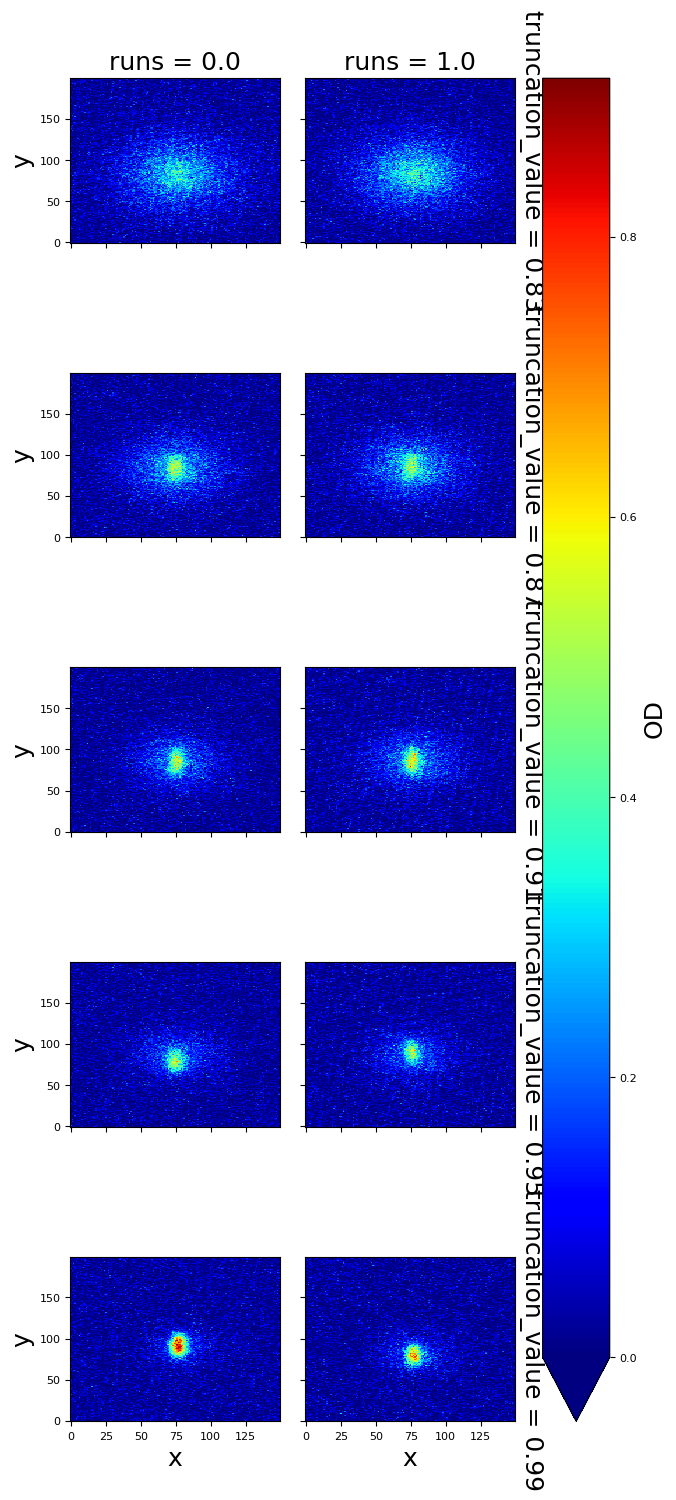

In [5]:
imageAnalyser.center = (960, 890)
imageAnalyser.span = (150, 200)
imageAnalyser.fraction = (0.1, 0.1)

dataSet_cropOD = imageAnalyser.crop_image(dataSet.OD)
dataSet_cropOD = imageAnalyser.substract_offset(dataSet_cropOD).load()
cropOD = dataSet_cropOD.to_numpy()
dataSet_cropOD.plot.pcolormesh(cmap='jet', vmin=0, col=scanAxis[1], row=scanAxis[0])
plt.show()

## Guess center

ToDo: Crop from center guess

In [6]:
# from opencv import moments
shape = np.shape(cropOD)
sigma = 0.4
blurred = gaussian_filter(cropOD, sigma=sigma)

thresh = np.zeros(shape)
for i in range(0,shape[0]):
    for j in range(0, shape[1]):
        thresh[i,j] = np.where(blurred[i,j] < np.max(blurred[i,j])*0.5,0,1)

# thresh = gaussian_filter(thresh, sigma=0.1)
# thresh = np.where(thresh<0.1,0,1)

#M = moments(thresh)

In [7]:
center = calc_cen_bulk(thresh)
print(center)

[[[76.98612316 83.06157849]
  [75.11961722 83.70813397]
  [75.59055118 84.61023622]
  [74.91266376 80.6069869 ]
  [76.890625   91.13541667]]

 [[77.40971719 84.36548223]
  [75.53406593 86.14505495]
  [76.15422886 86.86069652]
  [75.89119171 88.92746114]
  [77.05294118 80.42352941]]]


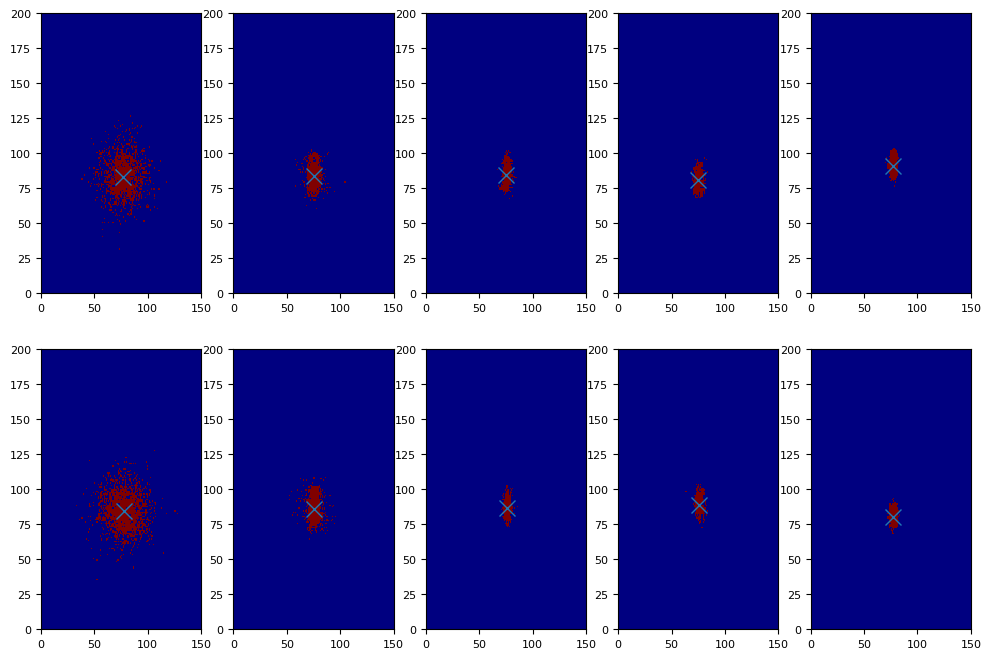

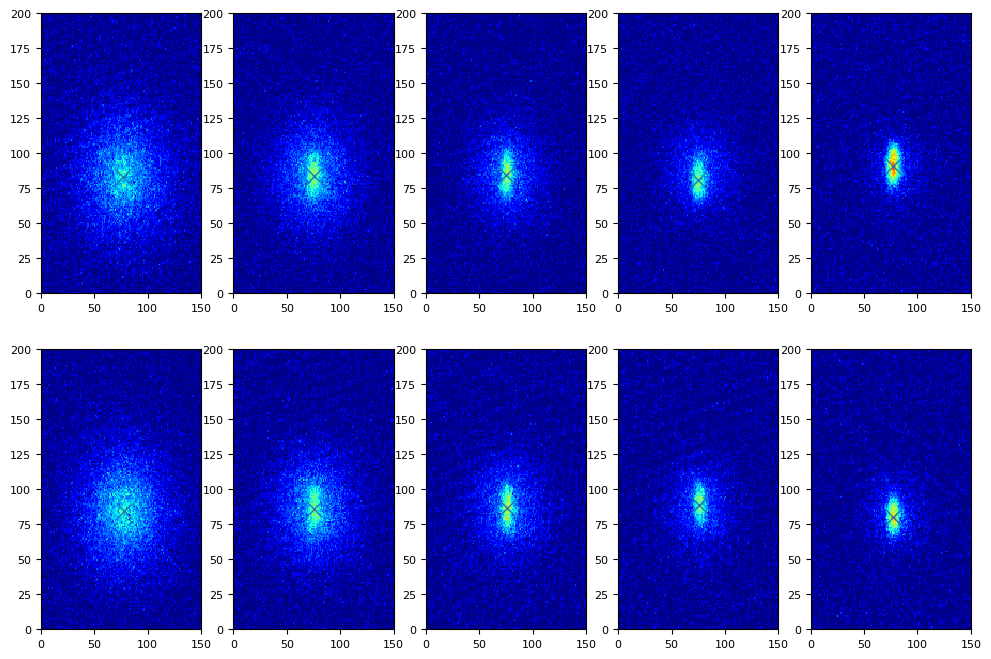

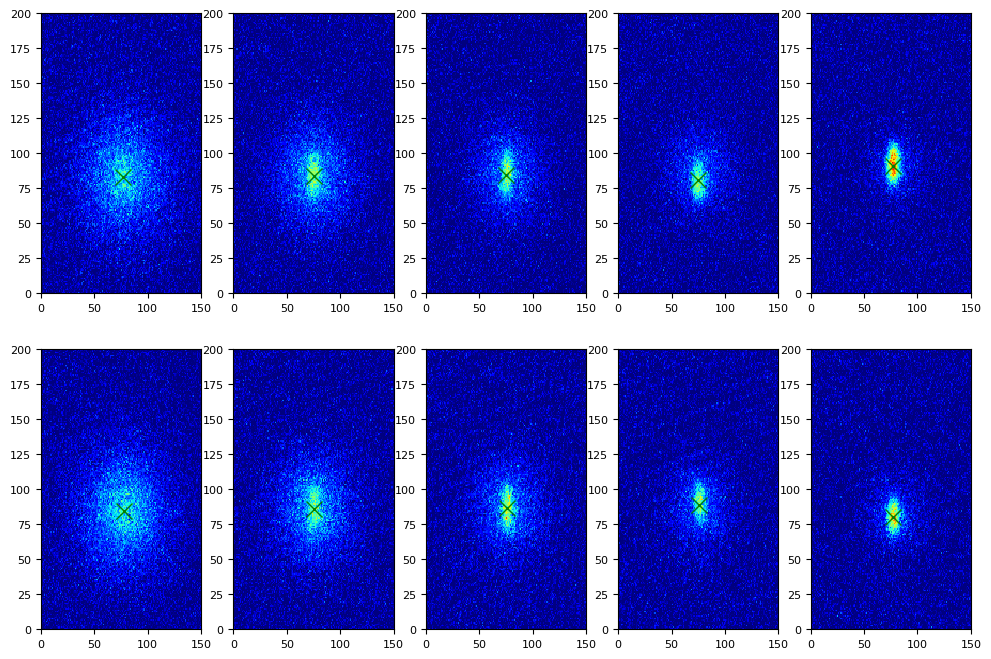

In [8]:
fsize = (12,8)

vmax = 1
fig, ax = plt.subplots(shape[0],shape[1],figsize=fsize)

for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        # ax[i][j].pcolormesh(blurred[i][j], cmap='jet', vmin=0, vmax=1.5, alpha=1)
        ax[i][j].pcolormesh(thresh[i][j], cmap='jet', vmin=0, vmax=1, alpha=1)
        #ax[i][j].pcolormesh(cropOD[i][j], cmap='hot', vmin=0, vmax=1, alpha=1)
        ax[i][j].plot(center[i,j,0],center[i,j,1], marker='x', markersize=12)
plt.show()

fig, ax = plt.subplots(shape[0],shape[1],figsize=fsize)
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        ax[i][j].pcolormesh(blurred[i][j], cmap='jet', vmin=0, vmax=vmax, alpha=1)
        #ax[i][j].pcolormesh(thresh[i][j], cmap='jet', vmin=0, vmax=1.5, alpha=1)
        #ax[i][j].pcolormesh(cropOD[i][j], cmap='hot', vmin=0, vmax=1, alpha=1)
        ax[i][j].plot(center[i,j,0],center[i,j,1], marker='x', markersize=12)
plt.show()

fig, ax = plt.subplots(shape[0],shape[1],figsize=fsize)
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        ax[i][j].pcolormesh(cropOD[i][j], cmap='jet', vmin=0, vmax=vmax)
        #ax[i][j].plot(max[i,j,1],max[i,j,0], marker='x', markersize=12)
        ax[i][j].plot(center[i,j,0],center[i,j,1], marker='x', color='g', markersize=12)
plt.show()

## Guess width

In [9]:
def guess_BEC_width(thresh, center):
    """
    returns width of thresholded area along both axis through the center with shape of thresh and [X_width, Y_width] for each image
    """
    shape = np.shape(thresh)
    BEC_width_guess = np.zeros((shape[0], shape[1], 2))

    for i in range(0, shape[0]):
        for j in range(0, shape[1]):
            BEC_width_guess[i, j, 0] = np.sum(thresh[i, j, round(center[i,j,1]), :])
            BEC_width_guess[i, j, 1] = np.sum(thresh[i, j, :, round(center[i,j,0])])

    return BEC_width_guess

BEC_width_guess = guess_BEC_width(thresh, center)

print(BEC_width_guess)

[[[30. 39.]
  [15. 30.]
  [ 9. 28.]
  [10. 25.]
  [10. 24.]]

 [[36. 44.]
  [15. 32.]
  [11. 28.]
  [ 8. 24.]
  [11. 22.]]]


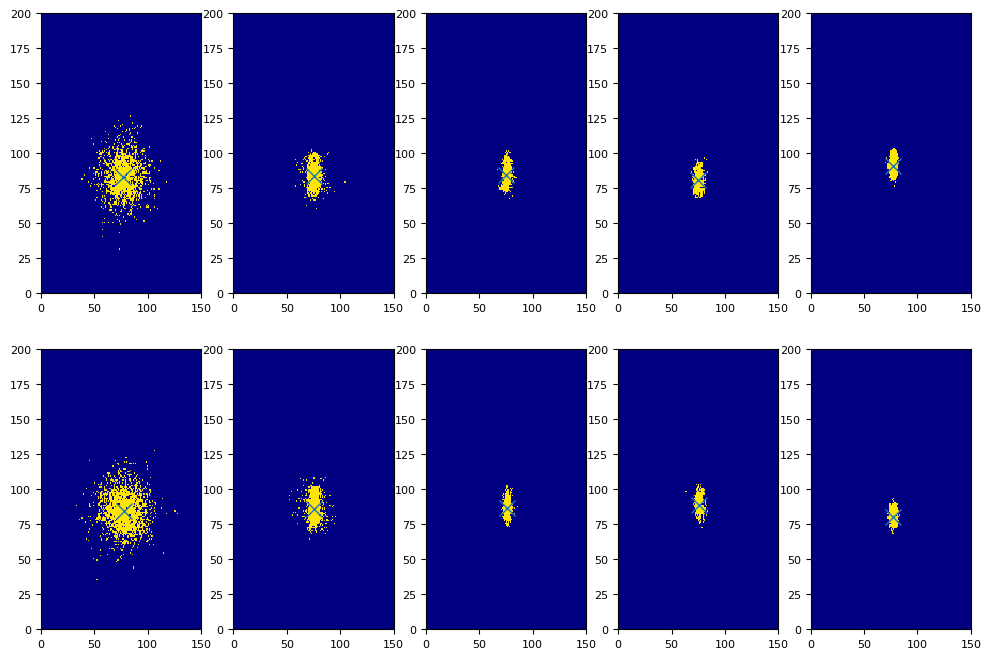

In [10]:
# %matplotlib notebook
fig, ax = plt.subplots(shape[0],shape[1],figsize=fsize)

for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        # ax[i][j].pcolormesh(blurred[i][j], cmap='jet', vmin=0, vmax=1.5, alpha=1)
        ax[i][j].pcolormesh(thresh[i][j], cmap='jet', vmin=0, vmax=1.5, alpha=1)
        #ax[i][j].pcolormesh(cropOD[i][j], cmap='hot', vmin=0, vmax=1, alpha=1)
        ax[i][j].plot(center[i,j,0],center[i,j,1], marker='x', markersize=12)
plt.show()


## Mask array

In [11]:
masked = np.where(thresh==0, cropOD, np.nan)
np.shape(masked)

(2, 5, 200, 150)

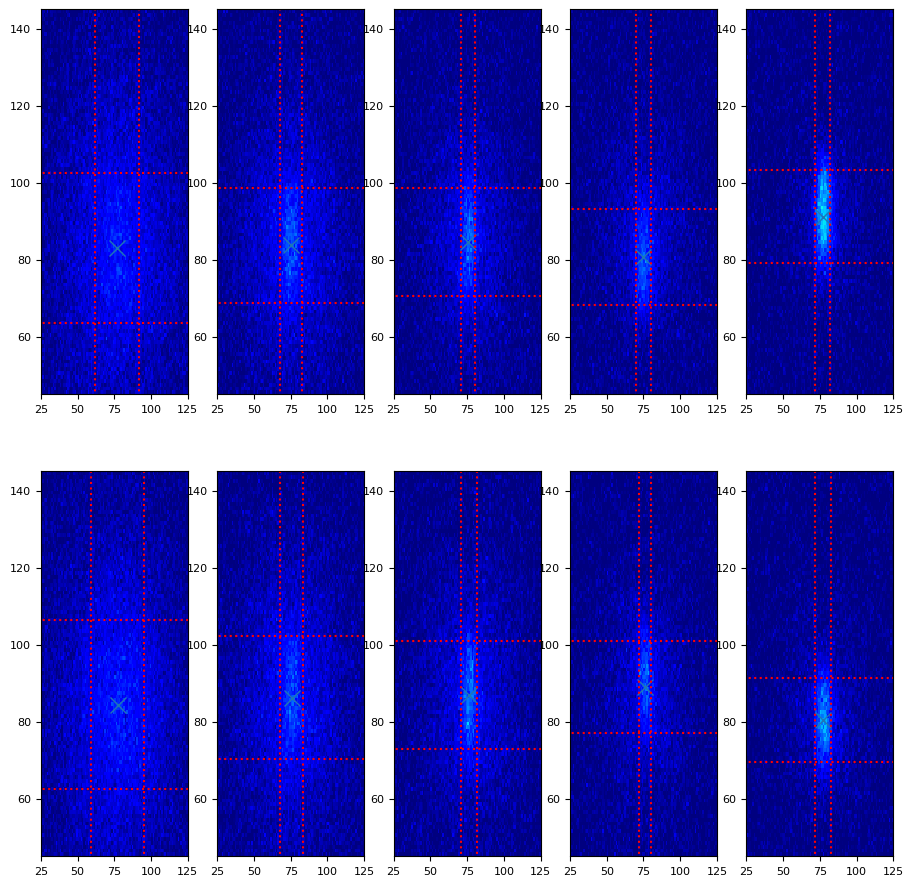

In [12]:
fig, ax = plt.subplots(shape[0],shape[1],figsize=(11,11))

cut_factor = 1

for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        #print(np.nanmax(masked[i,j]))
        # ax[i][j].pcolormesh(blurred[i][j], cmap='jet', vmin=0, vmax=1.5, alpha=1)
        #ax[i][j].pcolormesh(masked[i][j], cmap='jet', vmin=0, vmax=0.5, alpha=1)
        ax[i][j].pcolormesh(cropOD[i][j], cmap='jet', vmin=0, vmax=2.5, alpha=1)
        #ax[i][j].pcolormesh(thresh[i][j], cmap='jet', vmin=0, vmax=1.5, alpha=1)
        #ax[i][j].pcolormesh(cropOD[i][j], cmap='hot', vmin=0, vmax=1, alpha=1)
        ax[i][j].plot(center[i,j,0],center[i,j,1], marker='x', markersize=12)
        alpha=1
        ax[i][j].hlines(center[i,j,1] - cut_factor * BEC_width_guess[i,j,1]/2, 0, 150, color='r',alpha=alpha,linestyles='dotted')
        ax[i][j].hlines(center[i,j,1] + cut_factor * BEC_width_guess[i,j,1]/2, 0, 150, color='r',alpha=alpha,linestyles='dotted')

        ax[i][j].vlines(center[i,j,0] - cut_factor * BEC_width_guess[i,j,0]/2, 0, 200, color='r',alpha=alpha,linestyles='dotted')
        ax[i][j].vlines(center[i,j,0] + cut_factor * BEC_width_guess[i,j,0]/2, 0, 200, color='r',alpha=alpha,linestyles='dotted')

        ax[i][j].set_xlim(25,125)
        ax[i][j].set_ylim(45,145)
plt.show()

## Try with not masked array


In [13]:
shape = np.shape(masked)

X_guess_og = np.zeros((shape[0], shape[1], shape[3]))
Y_guess_og = np.zeros((shape[0], shape[1], shape[2]))

for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        X_guess_og[i,j] = np.sum(cropOD[i,j,round(center[i,j,1] - BEC_width_guess[i,j,1]/2) : round(center[i,j,1] + BEC_width_guess[i,j,1]/2) , :], 0) / len(masked[i,j,round(center[i,j,1] - BEC_width_guess[i,j,1]/2) : round(center[i,j,1] + BEC_width_guess[i,j,1]/2),0])

        Y_guess_og[i,j] = np.sum(cropOD[i,j, :, round(center[i,j,0] - BEC_width_guess[i,j,0]/2) : round(center[i,j,0] + BEC_width_guess[i,j,0]/2)], 1) / len(masked[i,j,0,round(center[i,j,0] - BEC_width_guess[i,j,0]/2) : round(center[i,j,0] + BEC_width_guess[i,j,0]/2)])

## Bimodal 1d Fit

In [14]:
#[nr images x, nr images y, X / Y, center / sigma]
x = np.linspace(0,149,150)
y = np.linspace(0,199, 200)

popt = np.zeros((shape[0], shape[1], 6))

p0 = np.ones((shape[0], shape[1], 6))

max = np.zeros((shape[0], shape[1]))

for i in range(0, shape[0]):
    max[i] = np.ndarray.max(X_guess_og[i],axis=1)


p0[:, :, 0] = center[:, :, 0]  # center BEC
p0[:, :, 1] = center[:, :, 0]   # center th
p0[:, :, 2] = 0.7 * max          # amp BEC
p0[:, :, 3] = 0.3 * max         # amp th
p0[:, :, 4] = BEC_width_guess[:, :, 0] / 1.22  # sigma BEC
p0[:, :, 5] = BEC_width_guess[:, :, 0] * 3          # sigma th

start = time.time()
for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        popt[i,j], pcov = curve_fit(density_1d, x, X_guess_og[i,j] , p0[i, j], nan_policy='omit')
stop = time.time()

print(f'fitting time: {(stop-start)*1e3} ms')
        #popt[i,j, 1], pcov = curve_fit(density_1d, y, Y_guess_og[i,j] , p0[i, j, 1], nan_policy='omit')

fitting time: 138.66639137268066 ms


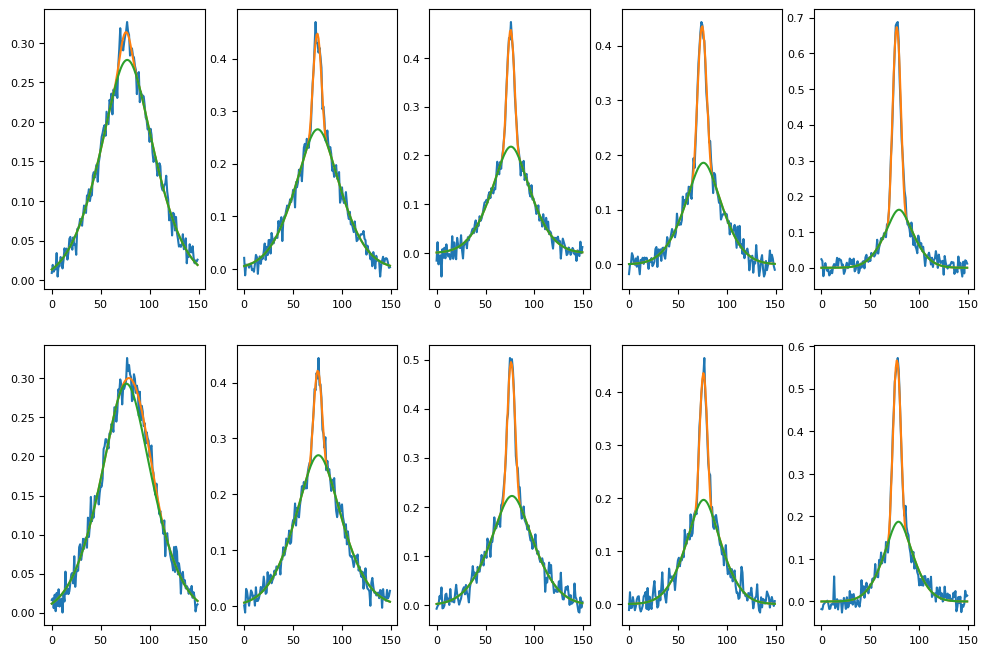

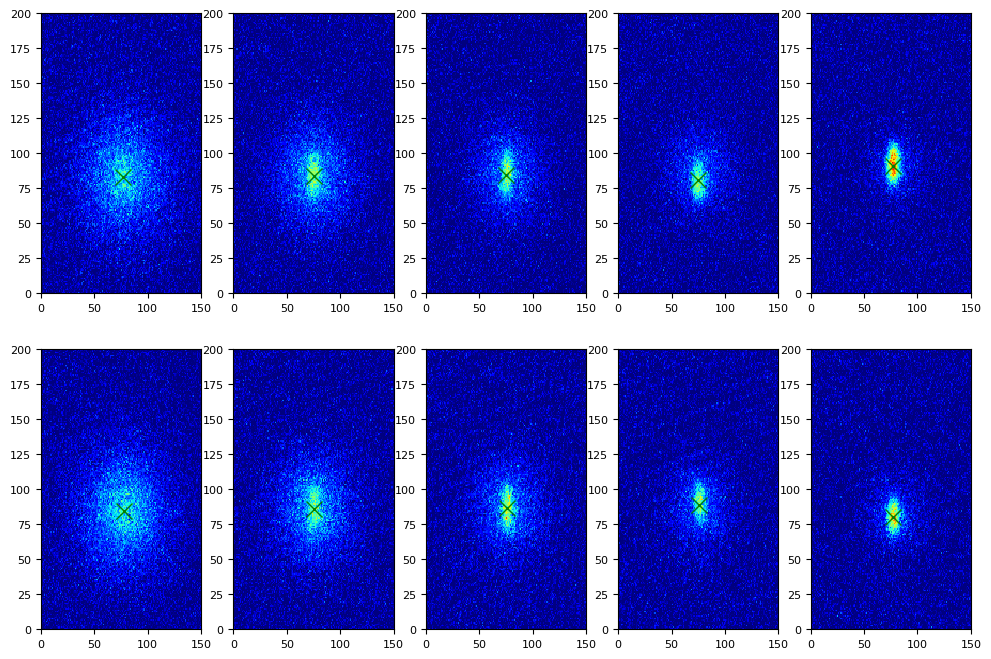

In [15]:
fig, ax = plt.subplots(shape[0],shape[1],figsize=fsize)
for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        lab = f"A$_{{BEC}}$ = {popt[i,j,0]:.1f} \n A$_{{th}}$ = {popt[i,j,1]:.1f} "
        ax[i,j].plot(x, X_guess_og[i,j])
        ax[i,j].plot(x, density_1d(x, *popt[i,j]), label = lab)
        ax[i,j].plot(x, thermal(x, popt[i,j,1], popt[i,j, 3], popt[i,j, 5]))


        #ax[i,j].legend(fontsize=10)
        ax[i,j].set_facecolor('#FFFFFF')
plt.show()

fig, ax = plt.subplots(shape[0],shape[1],figsize=fsize)
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        ax[i][j].pcolormesh(cropOD[i][j], cmap='jet', vmin=0, vmax=vmax)
        #ax[i][j].plot(max[i,j,1],max[i,j,0], marker='x', markersize=12)
        ax[i][j].plot(center[i,j,0],center[i,j,1], marker='x', color='g', markersize=12)
plt.show()

In [291]:
for i in range(0,3):
    for j in range(0,3):
        print(p0[i,j])
        print(popt[i,j])
        print("")

[75.69178082 75.69178082  1.28576093  0.5510404   6.55737705 24.        ]
[75.41570362 77.33387879  2.56706777  0.32435402  9.02534088 21.78912987]

[77.85648148 77.85648148  1.26012635  0.54005415  6.55737705 24.        ]
[77.87651572 81.11229756  2.46976235  0.33019909  9.77966756 21.30091787]

[74.20467836 74.20467836  1.24055688  0.53166723  7.37704918 27.        ]
[73.89357612 76.27664601  2.43121779  0.2744056   9.98643603 20.45775088]

[77.33333333 77.33333333  1.34319384  0.5756545   5.73770492 21.        ]
[77.11393649 81.4023359   2.8892113   0.26104137  8.62446159 18.7349952 ]

[74.9516129  74.9516129   1.37694159  0.59011782  5.73770492 21.        ]
[74.59730235 78.58391875  2.78343113  0.22862231  9.03244268 18.55359115]

[78.32758621 78.32758621  1.11153483  0.47637207  6.55737705 24.        ]
[78.50292398 82.4025832   2.35517042  0.20782941  9.17053528 15.99072519]

[76.02054795 76.02054795  0.47105793  0.20188197  6.55737705 24.        ]
[75.5176545  76.75506323  0.8743

## Fit Y

In [17]:
S = np.zeros((shape[0], shape[1]))
for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        S[i,j] = np.max(Y_guess_og[i,j])/(popt[i,j,2] + popt[i,j,3])
print(S)


[[1.29990174 0.83054958 0.81102892 0.78729    0.61898862]
 [1.46785552 0.86056717 0.78554798 0.88165254 0.66979222]]


In [20]:
# without mathematical constraint
# Fix most
fitmodel = lmfit.Model(density_1d,independent_vars=['x'])

p0_y = np.ones((shape[0], shape[1], 6))
popt_y = np.zeros((shape[0], shape[1], 6))


print(S[0,0]* popt[0,0,3]+S[0,0]* popt[0,0,2])

result = []
start = time.time()
for i in range(0, shape[0]):
    temp_res = []
    for j in range(0, shape[1]):
        params = lmfit.Parameters()
        params.add_many(
            ('x0_bec', center[i,j,1], False,0, 200),
            ('x0_th',center[i,j,1], False,0, 200),
            ('amp_bec', S[i,j]* popt[i,j,2], True, 0, 1.3 * np.max(Y_guess_og[i,j])),
            ('amp_th', S[i,j]* popt[i,j,3], False),
            ('sigma_bec',BEC_width_guess[i,j,1], True, 0, 50),
            ('sigma_th',popt[i,j,5], False)
        )
        res = fitmodel.fit(Y_guess_og[i,j], x=y, params=params)
        temp_res.append(res)
    result.append(temp_res)
stop = time.time()

0.32201295482940323


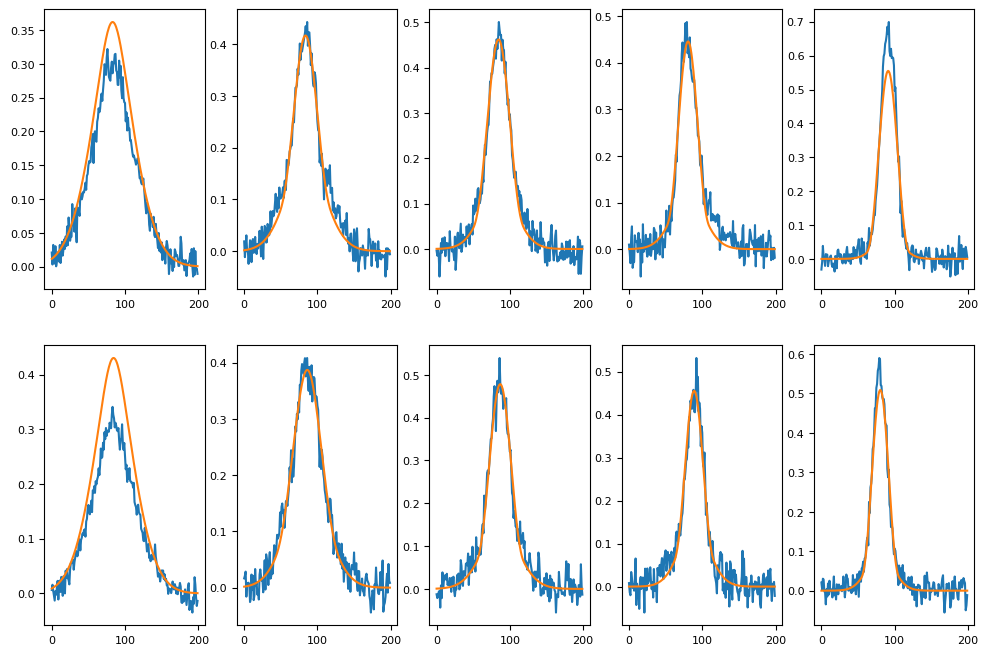

In [22]:
fig, ax = plt.subplots(shape[0],shape[1],figsize=fsize)
for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        #lab = f"A$_{{BEC}}$ = {popt[i,j,0]:.1f} \n A$_{{th}}$ = {popt[i,j,1]:.1f} "
        ax[i,j].plot(y, Y_guess_og[i,j])
        ax[i,j].plot(y, density_1d(y, **result[i][j].best_values), label = lab)
        #ax[i,j].plot(y, thermal(y, **result[i][j].best_values))


        #ax[i,j].legend(fontsize=10)
        ax[i,j].set_facecolor('#FFFFFF')
plt.show()